In [1]:
import pandas as pd
import numpy as np
from math import log
import os


In [3]:
# Load dataset
df = pd.read_csv('loan_data_created.csv')

x = df['default'].to_list()
y = df['fico_score'].to_list()
n = len(x)

print("Data points:", len(x), len(y))


Data points: 10000 10000


In [5]:
# Arrays to track defaults and totals per FICO score
default = [0 for _ in range(851)]
total = [0 for _ in range(851)]

for i in range(n):
    y[i] = int(y[i])
    default[y[i] - 300] += x[i]
    total[y[i] - 300] += 1

# Cumulative sums for smoother segmentation
for i in range(0, 551):
    default[i] += default[i - 1]
    total[i] += total[i - 1]



In [6]:
def log_likelihood(n, k):
    p = k / n
    if p == 0 or p == 1:
        return 0
    return k * np.log(p) + (n - k) * np.log(1 - p)


In [7]:
r = 10  # number of risk segments
dp = [[[-10**18, 0] for _ in range(551)] for _ in range(r + 1)]

for i in range(r + 1):
    for j in range(551):
        if i == 0:
            dp[i][j][0] = 0
        else:
            for k in range(j):
                if total[j] == total[k]:
                    continue
                val = log_likelihood(total[j] - total[k], default[j] - default[k])
                if i == 1:
                    dp[i][j][0] = log_likelihood(total[j], default[j])
                elif dp[i][j][0] < dp[i - 1][k][0] + val:
                    dp[i][j][0] = val + dp[i - 1][k][0]
                    dp[i][j][1] = k


In [8]:
print("Maximized Log-Likelihood:", round(dp[r][550][0], 4))

k = 550
segments = []
while r >= 0:
    segments.append(k + 300)
    k = dp[r][k][1]
    r -= 1

print("FICO Score Segmentation:", sorted(segments))


Maximized Log-Likelihood: -4217.8245
FICO Score Segmentation: [300, 520, 552, 580, 611, 649, 696, 732, 752, 753, 850]


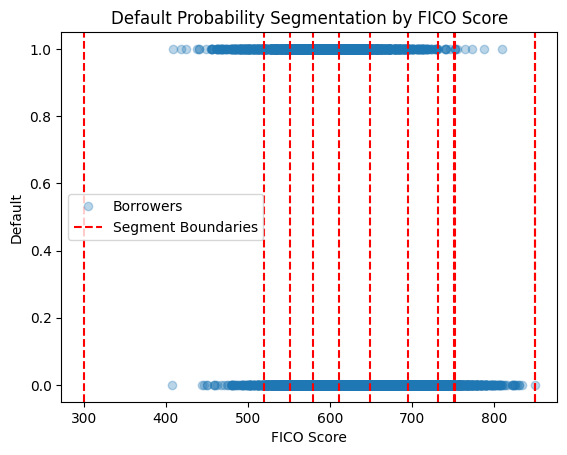

In [9]:
import matplotlib.pyplot as plt

plt.plot(y, x, 'o', alpha=0.3, label="Borrowers")
plt.axvline(x=segments[0], color='r', linestyle='--', label="Segment Boundaries")
for s in segments:
    plt.axvline(x=s, color='r', linestyle='--')
plt.xlabel("FICO Score")
plt.ylabel("Default")
plt.title("Default Probability Segmentation by FICO Score")
plt.legend()
plt.show()
